Training Errors:
D50:  Linear = 0.4800  |  Quadratic = 0.3200
D500:  Linear = 0.4120  |  Quadratic = 0.2840
D5000:  Linear = 0.3824  |  Quadratic = 0.2784


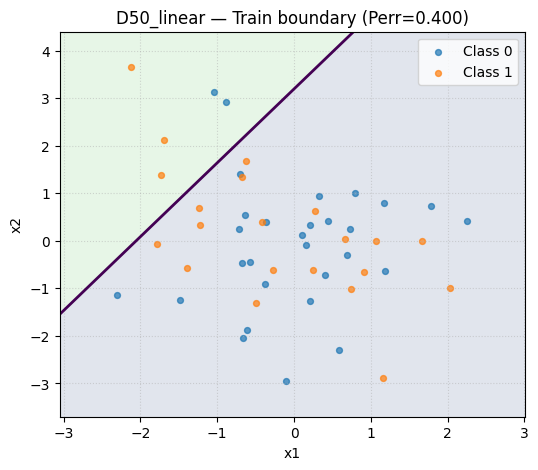

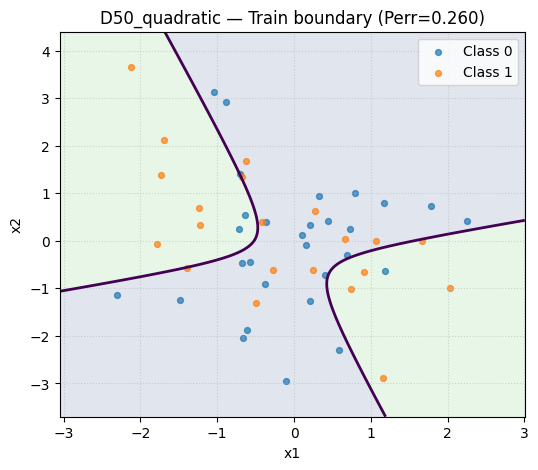

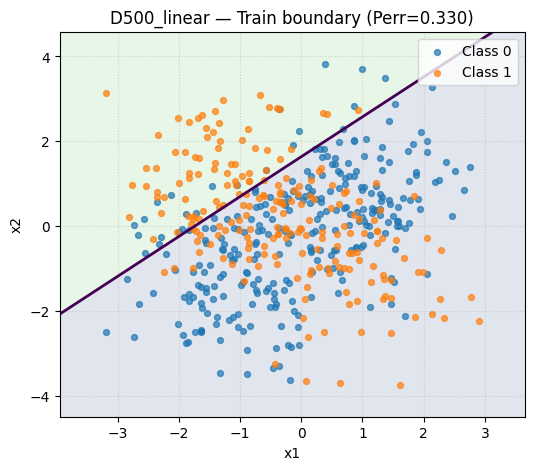

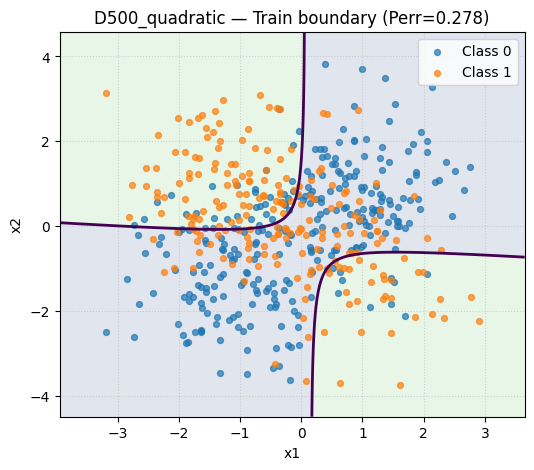

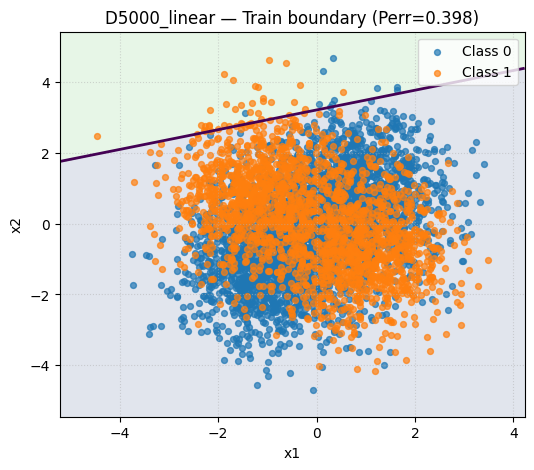

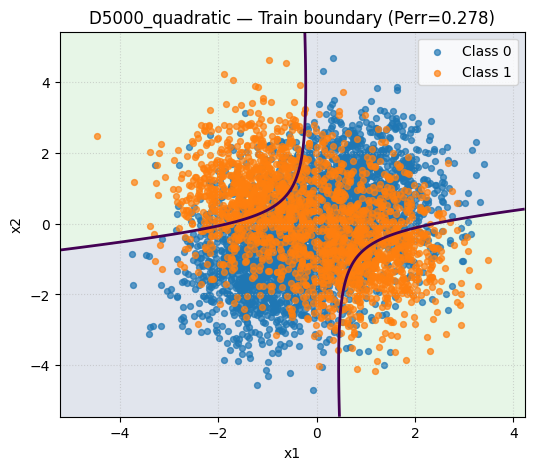

In [11]:
# Q1 Part 2 — Training errors first, then plots inline (Jupyter version)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

rng = np.random.default_rng(7)

# -----------------------------
# True data model
# -----------------------------
P0, P1 = 0.6, 0.4
m01 = np.array([-0.9, -1.1])
m02 = np.array([0.8, 0.75])
m11 = np.array([-1.1, 0.9])
m12 = np.array([0.9, -0.75])
C = np.diag([0.75, 1.25])

def sample_class(mu_list, n):
    comp = rng.integers(0, 2, size=n)
    X = np.empty((n, 2))
    for i in range(n):
        X[i] = rng.multivariate_normal(mu_list[comp[i]], C, method="eigh")
    return X

def make_dataset(N):
    n1 = rng.binomial(N, P1)
    n0 = N - n1
    X0 = sample_class([m01, m02], n0)
    X1 = sample_class([m11, m12], n1)
    X = np.vstack([X0, X1])
    y = np.concatenate([np.zeros(n0, dtype=int), np.ones(n1, dtype=int)])
    idx = rng.permutation(N)
    return X[idx], y[idx]

# ------------------------------
# Logistic model utilities
# ------------------------------
def z_linear(X): return np.c_[np.ones(len(X)), X]
def z_quadratic(X):
    x1, x2 = X[:, 0], X[:, 1]
    return np.c_[np.ones(len(X)), x1, x2, x1**2, x1*x2, x2**2]

def sigmoid(t):
    out = np.empty_like(t, dtype=float)
    pos = t >= 0; neg = ~pos
    out[pos] = 1 / (1 + np.exp(-t[pos]))
    exp_t = np.exp(t[neg]); out[neg] = exp_t / (1 + exp_t)
    return out

def fit_logistic(Z, y):
    w0 = np.zeros(Z.shape[1])
    def nll_grad(w):
        s = Z @ w
        p = sigmoid(s)
        eps = 1e-12
        nll = -np.sum(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))
        grad = Z.T @ (p - y)
        return nll, grad
    res = minimize(lambda w: nll_grad(w)[0], w0, jac=lambda w: nll_grad(w)[1], method="L-BFGS-B")
    return res.x

def classification_error(prob, y, thr=0.5):
    return np.mean((prob >= thr).astype(int) != y)

# ------------------------------
# Generate data & compute errors
# ------------------------------
sizes = [50, 500, 5000]
train_errors = {}

for N in sizes:
    X, y = make_dataset(N)
    w_lin = fit_logistic(z_linear(X), y)
    w_quad = fit_logistic(z_quadratic(X), y)
    p_lin, p_quad = sigmoid(z_linear(X) @ w_lin), sigmoid(z_quadratic(X) @ w_quad)
    perr_lin, perr_quad = classification_error(p_lin, y), classification_error(p_quad, y)
    train_errors[N] = (perr_lin, perr_quad)

# Print all training errors first
print("Training Errors:")
for N, (perr_lin, perr_quad) in train_errors.items():
    print(f"D{N}:  Linear = {perr_lin:.4f}  |  Quadratic = {perr_quad:.4f}")

# ------------------------------
# Plot decision boundaries (any one set)
# ------------------------------
def plot_decision_boundary(X, y, w, fmap, title):
    pad = 0.75
    x1min, x1max = X[:,0].min()-pad, X[:,0].max()+pad
    x2min, x2max = X[:,1].min()-pad, X[:,1].max()+pad
    xx1, xx2 = np.meshgrid(np.linspace(x1min, x1max, 400),
                           np.linspace(x2min, x2max, 400))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    Zgrid = fmap(grid) @ w
    Zgrid = Zgrid.reshape(xx1.shape)
    plt.figure(figsize=(6,5))
    plt.contourf(xx1, xx2, (Zgrid >= 0).astype(float), levels=[-1,0,1], alpha=0.15)
    plt.contour(xx1, xx2, Zgrid, levels=[0.0], linewidths=2)
    plt.scatter(X[y==0,0], X[y==0,1], s=18, alpha=0.7, label="Class 0")
    plt.scatter(X[y==1,0], X[y==1,1], s=18, alpha=0.7, label="Class 1")
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.legend(); plt.grid(True, ls=":", alpha=0.5)
    plt.show()

for N in [50, 500, 5000]:
    Xtr, ytr = make_dataset(N)
    # Linear
    w_lin = fit_logistic(z_linear(Xtr), ytr)
    perr_lin = classification_error(sigmoid(z_linear(Xtr) @ w_lin), ytr)
    plot_decision_boundary(Xtr, ytr, w_lin, z_linear, f"D{N}_linear — Train boundary (Perr={perr_lin:.3f})")

    # Quadratic
    w_quad = fit_logistic(z_quadratic(Xtr), ytr)
    perr_quad = classification_error(sigmoid(z_quadratic(Xtr) @ w_quad), ytr)
    plot_decision_boundary(Xtr, ytr, w_quad, z_quadratic, f"D{N}_quadratic — Train boundary (Perr={perr_quad:.3f})")

